In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import tensorflow as tf

from sklearn.cross_validation import train_test_split
from scipy.stats import wishart, invwishart, dirichlet

import edward as ed

from edward.models import Categorical, Dirichlet, InverseGamma, Mixture, \
    MultivariateNormalDiag, MultivariateNormalFull, Normal, WishartFull

/home/folzd/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def choose_colors(n):
    n_cubes_per_axis = np.int(np.ceil(n**(1/3)))
    step = 1/n_cubes_per_axis
    x = np.array(np.meshgrid(np.arange(0,1,step),np.arange(0,1,step),np.arange(0,1,step))).reshape(3,-1)
    return x[:,:n].T

In [3]:
d = 2
k = 10
n = 20000

In [4]:
alpha0 = 10 # alpha >> 1 yields equal amounts of data from each cluster, alpha << 1 yields one-cluster-dominated-data
m0 = np.ones(d)*0
#nu0 = 10*d # must satisfy nu0 > d-1
nu0 = 10*d
W0 = invwishart.rvs(df = nu0, scale=np.eye(d)) # covariance matrix of the normal distribution
beta0 = 0.01 # the bigger beta is, the more clustered are the clusters

true_parameters = {'alpha0':alpha0,'m0':m0,'nu0':nu0,'W0':W0,'beta0':beta0}

In [5]:
def simulate_data(d,k,n,alpha0,m0,nu0,W0,beta0):
    """
    Samples from a Bayesian Gaussian Mixture
    """
    # outermost/most latent variables
    pi = dirichlet.rvs(alpha=np.ones(k)*alpha0,size=1)
    #inv_lambda = [invwishart.rvs(df = nu0, scale=W0) for i in range(k)]
    lamda = [np.linalg.inv(wishart.rvs(df = nu0, scale=W0)) for i in range(k)]
    
    z = np.random.multinomial(1, *pi, size=n)
    mu = [np.random.multivariate_normal(mean=m0,cov = (1/beta0)*lamda[i], size=1) for i in range(k)]
    
    # Inv-lambda is the covmat both for the mean-prior and the data distribution, but should it be?
    Xks = np.array([np.random.multivariate_normal(mu[i][0],lamda[i],n) for i in range(k)])

    idxs = z.T.astype(np.bool)
    X = Xks[idxs]
    y = np.array([np.ones((n,1))*i for i in range(k)])
    y = y[idxs].astype(np.int)[:,0]
    
    # shuffle points, for the sake of realism, and because kfold down the road doesn't shuffle
    shuffle_idxs = np.random.permutation(n)
    return X[shuffle_idxs,:],y[shuffle_idxs]

In [6]:
X,y = simulate_data(d,k,n,**true_parameters)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.9)

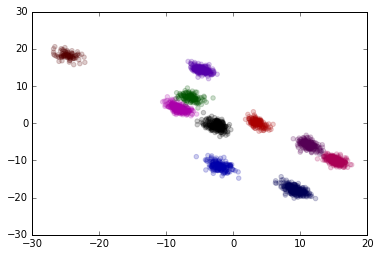

In [8]:
colors = choose_colors(k)
plt.scatter(X_train[:, 0], X_train[:, 1], color = colors[y_train], alpha=.2)
#plt.axis([-3, 3, -3, 3])
plt.show()

In [9]:
K = k
D = d
N = X_train.shape[0]
N_test = X_test.shape[0]

In [10]:
M = 100 # batch size

In [11]:
# Mixture of Gaussian model from Bishop 10.2

K = k
D = d

# expected shape is K x D x D
# df must be K x 1
# scale must be K x D x D
# WARNING: Make sure you're using either precisions or covariances consistently, or else invert them when appropriate
lamda = WishartFull(df = tf.ones([K])*nu0, scale = tf.stack([tf.cast(W0, tf.float32)]*K))
# expected shape is K x D
# mu must be D
# sigma must be D x D

# invert precisions, scale by beta0
invlamda = tf.map_fn(tf.matrix_inverse, lamda)
# See Bishop (10.40) on page 475: each component gets its own covmat
mu = MultivariateNormalFull(mu=tf.ones([K, D]) * m0, sigma=tf.map_fn(lambda x: (1/beta0)*x, invlamda))

pi = Dirichlet(tf.ones(K)*alpha0)
z = Categorical(p=tf.stack([pi]*N))
#z = Categorical(p=tf.stack([pi]*M)) # probabilistic model must anticipate batch sizes

components = [
    MultivariateNormalFull(mu=tf.ones([N, 1]) * tf.gather(mu, k), \
                           sigma=tf.stack([tf.gather(lamda, k)]*N)) for k in range(K)]
#components = [
#    MultivariateNormalFull(mu=tf.ones([M, 1]) * tf.gather(mu, k), \
#                           sigma=tf.stack([tf.gather(lamda, k)]*M)) for k in range(K)]

# output shold be N x D
x = Mixture(cat=z, components=components)

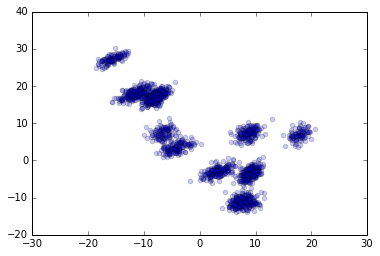

In [12]:
sess = tf.Session()
with sess.as_default():
    #print(p.sample().eval())
    #plt.hist(pi.sample().eval())
    #plt.figure()
    X_train_tmp = x.sample().eval()
    plt.scatter(X_train_tmp[:, 0], X_train_tmp[:, 1], alpha=.2)

In [13]:
# from https://github.com/blei-lab/edward/blob/master/examples/tf_mixture_gaussian.py
#qpi_alpha = tf.nn.softplus(tf.Variable(tf.random_normal([K])))
#qmu_mu = tf.Variable(tf.random_normal([K * D]))
#qmu_sigma = tf.nn.softplus(tf.Variable(tf.random_normal([K * D])))
#qsigma_alpha = tf.nn.softplus(tf.Variable(tf.random_normal([K * D])))
#qsigma_beta = tf.nn.softplus(tf.Variable(tf.random_normal([K * D])))

#qpi = Dirichlet(alpha=qpi_alpha)
#qmu = Normal(mu=qmu_mu, sigma=qmu_sigma)
#qsigma = InverseGamma(alpha=qsigma_alpha, beta=qsigma_beta)

In [14]:
# variational model from 476
qlambda_df = tf.squeeze(tf.Variable(tf.random_normal([K])))
qlambda_scale = tf.Variable(tf.random_normal([K,D,D]))
qmu_mu = tf.Variable(tf.random_normal([K, D]))
qmu_sigma = tf.Variable(tf.random_normal([K,D,D]))
qpi_alpha = tf.nn.softplus(tf.Variable(tf.random_normal([K])))
qz_p = ed.to_simplex(tf.Variable(tf.random_normal([K - 1])))
qzs = tf.stack([qz_p]*N)
#zs = tf.Variable(tf.zeros([N]))

qlambda = WishartFull(df = qlambda_df, scale = qlambda_scale)
# should the sigma here be it's own variational parameter, or do we invert somehow invert qlambda?
qmu = MultivariateNormalFull(mu = qmu_mu, sigma = qmu_sigma)
qpi = Dirichlet(alpha = qpi_alpha)
qz = Categorical(p = qzs)
#qz = Categorical(logits = zs)

In [15]:
qzs

<tf.Tensor 'stack_12:0' shape=(2000, 10) dtype=float32>

In [16]:
lamda,qlambda

(<ed.RandomVariable 'WishartFull/' shape=(10, 2, 2) dtype=tf.float32>,
 <ed.RandomVariable 'WishartFull_1/' shape=(10, 2, 2) dtype=tf.float32>)

In [17]:
mu,qmu

(<ed.RandomVariable 'MultivariateNormalFull/' shape=(10, 2) dtype=tf.float32>,
 <ed.RandomVariable 'MultivariateNormalFull_11/' shape=(10, 2) dtype=tf.float32>)

In [18]:
z,qz

(<ed.RandomVariable 'Categorical/' shape=(2000,) dtype=tf.int32>,
 <ed.RandomVariable 'Categorical_1/' shape=(2000,) dtype=tf.int32>)

In [19]:
inference = ed.KLqp({z: qz, pi: qpi, mu: qmu, lamda: qlambda}, data={x: X_train})

In [20]:
inference.run(n_iter=3000, n_samples=10, n_minibatch=8)

KeyboardInterrupt: 

In [ ]:
variables = [qlambda_df, qlambda_scale, qmu_mu, qmu_sigma, qpi_alpha, qz_p, qzs]

    1. Initialize algorithm via ``initialize``.
    2. (Optional) Build a TensorFlow summary writer for TensorBoard.
    3. (Optional) Initialize TensorFlow variables.
    4. (Optional) Start queue runners.
    5. Run ``update`` for ``self.n_iter`` iterations.
    6. While running, ``print_progress``.
    7. Finalize algorithm via ``finalize``.
    8. (Optional) Stop queue runners.

In [20]:
sess = ed.get_session()
#init = tf.initialize_all_variables()
init = tf.global_variables_initializer()
init.run()

inference.update()

AttributeError: 'KLqp' object has no attribute 'train'

In [23]:
#inference.run(n_iter=3000, n_samples=10)
inference.run(n_iter=1, n_samples=1, n_minibatch=1)

KeyboardInterrupt: 

In [15]:
#qz_logits = tf.Variable(tf.zeros([N, K]))

#idx_ph = tf.placeholder(tf.int32, M)

#qz = Categorical(logits=tf.gather(qz_logits, idx_ph))
#qz = Categorical(logits=qc_logits)

def next_batch(M):
    idx_batch = np.random.choice(N, M)
    return X_train[idx_batch, :], idx_batch

sess = tf.Session()
with sess.as_default():
    tf.global_variables_initializer().run()
    x_batch, idx_batch = next_batch(M)
    print(idx_batch)
    print(sess.run(qz.sample(), feed_dict={idx_ph: idx_batch}))

#Below, we update local variables five times for every global variable update.

# this placeholder allows us to feed data into the inference one M-sized batch at a time
x_ph = tf.placeholder(tf.float32, [M, D])

x, x_ph

z, qz

# from https://github.com/blei-lab/edward/issues/314
inference_global = ed.KLqp({pi: qpi, mu: qmu, lamda: qlambda}, data={x: x_ph, z: qz})
inference_local = ed.KLqp({z: qz}, data={x: x_ph, pi: qpi, mu: qmu, lamda: qlambda})

N_ITER = 100

for t in range(N_ITER):
    x_batch, idx_batch = next_batch(M)
    for _ in range(5):
        inference_local.update(feed_dict={x_ph: x_batch, idx_ph: idx_batch})
    info_dict = inference_global.update(feed_dict={x_ph: x_batch, idx_ph: idx_batch})
    inference_global.print_progress(info_dict)

In [24]:
inference_global.latent_vars

{<ed.RandomVariable 'MultivariateNormalFull/' shape=(10, 2) dtype=tf.float32>: <ed.RandomVariable 'MultivariateNormalFull_11/' shape=(10, 2) dtype=tf.float32>,
 <ed.RandomVariable 'WishartFull/' shape=(10, 2, 2) dtype=tf.float32>: <ed.RandomVariable 'WishartFull_1/' shape=(10, 2, 2) dtype=tf.float32>,
 <ed.RandomVariable 'Dirichlet/' shape=(10,) dtype=tf.float32>: <ed.RandomVariable 'Dirichlet_1/' shape=(10,) dtype=tf.float32>}

In [36]:
inference_local.latent_vars

{<ed.RandomVariable 'Categorical/' shape=(100,) dtype=tf.int32>: <ed.RandomVariable 'Categorical_2/' shape=(100,) dtype=tf.int32>}